In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import project_path
from project_path import (
    module_path,
    configuration_dir, 
    data_dir, 
    report_dir,
    model_dir
)
from shorelineforecasting.utils.configs import GluonConfigs

In [2]:
tf = GluonConfigs.load_data()
tf = tf.set_index('transect_id')
tf = tf.dropna(thresh=33)
print(f"Transects included in dataset: {tf.shape[0]}; timesteps: {tf.shape[1]}")
tf.head()

Transects included in dataset: 37111; timesteps: 33


,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
transect_id,,,,,,,,,,,,,,,,,,,,,
BOX_051_151_15,677.32043,695.66370,713.29486,682.1743,688.23425,672.13007,700.43286,693.43460,699.38560,687.97950,...,700.6640,712.41740,708.45123,740.33240,680.42510,758.35150,754.49695,763.04297,743.29680,779.41570
BOX_051_151_18,768.93800,769.23883,762.44300,755.8622,761.79663,760.51710,763.30505,761.81360,769.22100,765.47060,...,763.1057,759.72600,766.23150,770.77130,798.26830,797.99615,803.90950,797.90780,798.18830,803.68256
BOX_051_151_21,711.41626,684.20540,695.49817,701.6695,705.29990,703.61470,707.69403,692.90360,704.68280,704.99945,...,825.8698,820.51720,820.68680,842.18097,850.45460,775.96700,883.04240,867.92426,877.37415,874.50244
BOX_051_151_30,795.81573,820.63700,799.72380,799.8664,823.56260,822.07300,823.56800,823.73300,824.58400,824.33360,...,823.7820,823.15674,823.65790,821.31860,818.85803,817.31220,822.92970,818.73350,822.18480,818.73480
BOX_051_151_32,242.70204,238.05159,229.93718,244.0620,247.68105,257.49900,302.69217,301.27722,301.12033,316.40414,...,301.1231,313.63553,313.09814,312.90347,306.18658,294.18326,297.23654,302.88650,323.85840,304.36823


In [3]:
sites = pd.read_csv("/media/storage/data/shorelines/sites-gluonts-prepared-37k.csv")
sites = sites.loc[sites['transect_id'].isin(tf.index)]
print(f"Transects included in dataset: {sites.shape[0]}; metadata columns: {sites.shape[1]}")
sites.head()

Transects included in dataset: 37111; metadata columns: 27


,transect_id,country_id,continent,country_name,changerate,changerate_unc,flag_sandy,no_shorelines,RMSE,Timespan,...,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,coastline_idint,geometry,dbscan_cluster,fcluster,optics_clusters
0,BOX_051_170_3,ARG,South America,Argentina,0.389332,0.344834,True,33.0,18.281954,32.0,...,-36.378387,-56.709120,-36.376892,-56.700333,-36.375397,7427,POINT (-56.70912170410156 -36.37689208984375),0,2455,0
1,BOX_051_170_4,ARG,South America,Argentina,0.501007,0.390176,True,33.0,20.685827,32.0,...,-36.374847,-56.710050,-36.373356,-56.701260,-36.371860,7427,POINT (-56.71004867553711 -36.37335586547852),0,2455,0
2,BOX_051_170_5,ARG,South America,Argentina,0.831012,0.331491,True,33.0,17.574545,32.0,...,-36.371933,-56.711193,-36.369860,-56.702587,-36.367786,7427,POINT (-56.7111930847168 -36.3698616027832),0,2455,0
3,BOX_051_170_6,ARG,South America,Argentina,1.471142,0.277497,True,33.0,14.711926,32.0,...,-36.368470,-56.712482,-36.366394,-56.703876,-36.364323,7427,POINT (-56.71248245239258 -36.36639404296875),0,2455,0
4,BOX_051_170_7,ARG,South America,Argentina,2.159336,0.288062,True,33.0,15.272047,32.0,...,-36.365000,-56.713768,-36.362930,-56.705162,-36.360855,7427,POINT (-56.71376800537109 -36.36293029785156),0,2455,0


In [4]:
metadata = {
    'num_series': len(tf),
    'num_steps': len(tf.columns),
    'prediction_length': 7,
    'freq': "AS",
    'start': [pd.Timestamp("01-01-1984", freq='AS') for _ in range(len(tf))],
    'item_id': tf.index.values,
    'epochs': 10,
    'save_model': True,
    'evaluate_model': True,
}

In [5]:
from sklearn import preprocessing


transformations = {
    "standarize": preprocessing.StandardScaler(),
    "min-max-scale": preprocessing.MinMaxScaler()
}

rebase = lambda x: x-x[0]

def scale_df(df, method):
    x = df.values
    scaler = transformations[method]
    x_scaled = scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, index=df.index, columns=df.columns)

tf_t = tf.apply(rebase, axis=1)
tf_z = scale_df(tf.T, method='standarize').T


In [6]:
len(sites['fcluster'].unique())

8938

In [7]:
len(sites['dbscan_cluster'].unique())

13311

In [8]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName


def traverse(o, tree_types=(list, tuple)):
    if isinstance(o, tree_types):
        for value in o:
            for subvalue in traverse(value, tree_types):
                yield subvalue
    else:
        yield o


def get_gluon_ds(df, metadata, sites, cat_vars=['fcluster', 'dbscan_cluster'], 
                 sample=None, shuffle=False, get_transects=None):
    
    if get_transects is not None:
        df = df.loc[get_transects]
    
    if sample is not None:
        df = df.sample(sample)
        
    if shuffle is True:
        df = df.sample(frac=1)
        
    metadata_ = metadata.copy()
    metadata_['num_series'] = len(df)
    metadata_['item_id'] = df.index.values
    metadata_['start'] = metadata['start'][:len(df)]
    
    sites_ = sites.copy()
    sites_ = sites_.loc[sites_['transect_id'].isin(df.index)]
    sites_ = sites_.set_index('transect_id')
    sites_ = sites_.reindex(df.index)
    
    features = dict()
    features['num_series'] = metadata_['num_series']
    for cat in traverse(cat_vars):
        features[cat] = sites_[cat].unique()
        features[cat] = sites_[cat].unique()
    features['cat_vars'] = cat_vars
    
    train_ds = ListDataset(
        [
         {
             FieldName.TARGET: target,
             FieldName.START: start,
             FieldName.ITEM_ID: item_id,
             FieldName.FEAT_STATIC_CAT: [fclust, dbclust],
             FieldName.FEAT_STATIC_REAL: [fsr]
          }

         for (target, start, item_id, fclust, dbclust, fsr) in zip(df.values[:, :-metadata_['prediction_length']],
                                            metadata_['start'], 
                                            metadata_['item_id'],
                                            sites_['fcluster'].values,
                                            sites_['dbscan_cluster'].values,
                                            sites_['changerate_unc'].values)
        ], freq=metadata_['freq'])

    test_ds = ListDataset(
        [
         {
             FieldName.TARGET: target,
             FieldName.START: start,
             FieldName.ITEM_ID: item_id,
             FieldName.FEAT_STATIC_CAT: [fclust, dbclust],
             FieldName.FEAT_STATIC_REAL: [fsr]
          }

         for (target, start, item_id, fclust, dbclust, fsr) in zip(df.values,
                                            metadata_['start'], 
                                            metadata_['item_id'],
                                            sites_['fcluster'].values,
                                            sites_['dbscan_cluster'].values,
                                            sites_['changerate_unc'].values)
        ], freq=metadata_['freq'])
          
    return train_ds, test_ds, features

In [9]:
train_ds, test_ds, features = get_gluon_ds(tf_t, metadata, sites, sample=1000)

In [10]:
import inspect
from pathlib import Path

from gluonts.distribution.piecewise_linear import PiecewiseLinearOutput
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

from shorelineforecasting.utils.configs import get_predictor_id


def get_cls_attributes(cls):
    attributes = inspect.getmembers(cls, lambda x: not(inspect.isroutine(x)))
    attributes = [a for a in attributes if not(a[0].startswith('__') and a[0].endswith('__'))]
    return dict(attributes)


def get_hyperparams(estimator, predictor_id):
    predictor = type(estimator).__name__
    estimator_attr = get_cls_attributes(estimator)
    if predictor == 'RForecastPredictor':
        estimator_attr['predictor'] = predictor
        estimator_attr['predictor_id'] = predictor_id
        return dict(estimator_attr)
    trainer_attr = get_cls_attributes(estimator_attr['trainer'])
    attributes = {**estimator_attr, **trainer_attr}
    attributes.pop('trainer', None)
    attributes['predictor'] = predictor
    attributes['predictor_id'] = predictor_id
    return dict(attributes)


def to_model_database(attributes):
    fpath = os.path.join(data_dir, 'robustness-final.csv')
    if not os.path.exists(fpath):
        pd.DataFrame([attributes]).to_csv(fpath, header=True, index=False)
        return print(f"Created metrics database: {fpath}")
    params = pd.read_csv(fpath)
    to_add_params = pd.DataFrame([attributes])
    updated_params = pd.concat([params, to_add_params], axis=0, ignore_index=True)
    updated_params.to_csv(fpath, header=True, index=False)
    return print(f"Updated metrics database: {fpath}")


def get_cardinality(features):
    res = list()
    for cat in traverse(features['cat_vars']):
        res.append(len(features[cat]))
    return res

In [11]:
from functools import partial

from gluonts.model.r_forecast import RForecastPredictor
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.seq2seq import MQCNNEstimator
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepstate import DeepStateEstimator

from gluonts.trainer import Trainer

def get_estimators():
    estimators = [
        partial(
            SimpleFeedForwardEstimator,
            freq=metadata["freq"],
            context_length=context_length,
            trainer=Trainer(
                epochs=epochs, 
                num_batches_per_epoch=num_batches_per_epoch,
                batch_size=batch_size
            ),
        ),
        partial(
            DeepAREstimator,
            freq="12M",
            context_length=context_length,
            use_feat_static_real=True,
            use_feat_static_cat=True,
            cardinality=get_cardinality(features),
            time_features=[],
            trainer=Trainer(
                epochs=epochs, 
                num_batches_per_epoch=num_batches_per_epoch,
                batch_size=batch_size
            ),
        ),
        partial(
            MQCNNEstimator,
            freq=metadata["freq"],
            context_length=context_length,
            trainer=Trainer(
                epochs=epochs, 
                num_batches_per_epoch=num_batches_per_epoch,
                batch_size=batch_size
            ),
        ),
        partial(
            DeepStateEstimator,
            freq="12M",
            past_length=context_length,
            use_feat_static_cat=True,
            cardinality=get_cardinality(features),
            add_trend=True,
            time_features = [],
            trainer=Trainer(
                epochs=epochs, 
                num_batches_per_epoch=num_batches_per_epoch,
                batch_size=batch_size
            ),
        ),
        partial(
            RForecastPredictor,
            freq=metadata["freq"],
            method_name="arima"
        ),
        partial(
            RForecastPredictor,
            freq=metadata["freq"],
            method_name="ets"
        ),
    ]
    return estimators

In [12]:
def train_eval_loop(estimator, train_ds, test_ds):

    estimator = estimator(
        prediction_length=metadata['prediction_length']
    )
    
    predictor_id = get_predictor_id()
    attributes = get_hyperparams(estimator, predictor_id)
    
    if type(estimator).__name__ != 'RForecastPredictor':
        predictor = estimator.train(train_ds)
        
        if metadata['save_model'] is True:
            mpath = os.path.join(model_dir, f"{attributes['predictor']}-{predictor_id}")
            if not os.path.exists(mpath):
                os.mkdir(mpath)
            predictor.serialize(Path(mpath))
    else:
        predictor = estimator

    if metadata['evaluate_model'] is True:
        start = time.process_time()
        forecast_it, ts_it = make_evaluation_predictions(
            test_ds, predictor=predictor, num_samples=300
        )

        forecasts_ = list(forecast_it)
        tss_ = list(ts_it)        
        
        agg_metrics_, item_metrics_ = Evaluator()(
            iter(tss_), iter(forecasts_), num_series=len(test_ds)
        )
        attributes['processing_time'] = time.process_time() - start
        attributes = {**attributes, **agg_metrics_}
        print(agg_metrics_)

        to_model_database(attributes)
        
        return agg_metrics_, item_metrics_
    

In [13]:
import time 


def train_pred_loop(estimator, test_ds):
    
    estimator = estimator(
        prediction_length=metadata['prediction_length']
    )
    
    predictor_id = get_predictor_id()
    attributes = get_hyperparams(estimator, predictor_id)
    
    if type(estimator).__name__ != 'RForecastPredictor':
        predictor = estimator.train(test_ds)
        
        if metadata['save_model'] is True:
            mpath = os.path.join(model_dir, f"{attributes['predictor']}-{predictor_id}")
            if not os.path.exists(mpath):
                os.mkdir(mpath)
            predictor.serialize(Path(mpath))
            print(f'Saved {type(estimator).__name__} to {mpath}')
    else:
        predictor = estimator

### Params

In [14]:
context_length=2*metadata['prediction_length'] # for default evaluation
# context_length=11 # when evaluating over gradually increasing prediction length (33/3=11)
batch_size = 32
epochs = 100
num_batches_per_epoch = 50

In [52]:
agg_metrics, item_metrics = list(), list()
for prediction_length in np.arange(7, 8):
    metadata['prediction_length'] = prediction_length
    metadata['save_model'] = False
    train_ds, test_ds, features = get_gluon_ds(tf_t, metadata, sites)
    estimators = get_estimators()
    for estimator in estimators[4:]:    
        agg_metrics_, item_metrics_ = train_eval_loop(estimator, train_ds, test_ds)
        agg_metrics.append(agg_metrics_)
        item_metrics.append(item_metrics_)




    

/media/storage/dev/shorelineforecasting/shorelineforecasting/venv/lib/python3.8/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

  warnings.warn(x, RRuntimeWarning)
Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 213543.75it/s]


{'MSE': 2037.9864805102732, 'abs_error': 4450756.266372041, 'abs_target_sum': 9442682.196686804, 'abs_target_mean': 36.349184865045046, 'seasonal_error': 13.435315958841139, 'MASE': 1.3751770970622872, 'MAPE': 13.365188818007619, 'sMAPE': 0.8777188105178866, 'OWA': nan, 'MSIS': 16.98340481947103, 'QuantileLoss[0.1]': 2188969.497025785, 'Coverage[0.1]': 0.11995673212024158, 'QuantileLoss[0.2]': 3279557.411018102, 'Coverage[0.2]': 0.2079321879920085, 'QuantileLoss[0.3]': 3952813.1336378157, 'Coverage[0.3]': 0.29667753496267946, 'QuantileLoss[0.4]': 4313359.774591853, 'Coverage[0.4]': 0.38853709142841747, 'QuantileLoss[0.5]': 4450756.266372041, 'Coverage[0.5]': 0.4970378439969666, 'QuantileLoss[0.6]': 4518177.840598679, 'Coverage[0.6]': 0.6008076157627503, 'QuantileLoss[0.7]': 4357544.692271613, 'Coverage[0.7]': 0.6921320979147499, 'QuantileLoss[0.8]': 3867533.093373214, 'Coverage[0.8]': 0.7794300496194813, 'QuantileLoss[0.9]': 2929449.005167, 'Coverage[0.9]': 0.8649341550637663, 'RMSE': 

Running evaluation: 100%|██████████| 37111/37111 [00:00<00:00, 227942.09it/s]


{'MSE': 1993.203996073621, 'abs_error': 4318595.111756181, 'abs_target_sum': 9442682.196686804, 'abs_target_mean': 36.349184865045046, 'seasonal_error': 13.435315958841139, 'MASE': 1.3449238256471217, 'MAPE': 11.809112682123361, 'sMAPE': 0.8359587682359937, 'OWA': nan, 'MSIS': 16.55591834141187, 'QuantileLoss[0.1]': 2143344.790480035, 'Coverage[0.1]': 0.12929551114994783, 'QuantileLoss[0.2]': 3200190.4417155525, 'Coverage[0.2]': 0.2209087024640364, 'QuantileLoss[0.3]': 3856043.546920824, 'Coverage[0.3]': 0.31134396039680184, 'QuantileLoss[0.4]': 4203091.124032142, 'Coverage[0.4]': 0.4018523579839632, 'QuantileLoss[0.5]': 4318595.111756181, 'Coverage[0.5]': 0.50126454612995, 'QuantileLoss[0.6]': 4361538.454888257, 'Coverage[0.6]': 0.5986442217748298, 'QuantileLoss[0.7]': 4184569.7776674065, 'Coverage[0.7]': 0.6879053957817667, 'QuantileLoss[0.8]': 3691561.4553689994, 'Coverage[0.8]': 0.7751417561985858, 'QuantileLoss[0.9]': 2776698.3058764706, 'Coverage[0.9]': 0.8617929993802377, 'RMSE'

In [58]:
tmp = pd.read_csv(os.path.join(data_dir, 'processing-speed.csv'))
tmp2 = tmp[['predictor', 'method_name', 'processing_time']]
tmp2['proc_time(min)'] = tmp2['processing_time']/60

<ipython-input-58-75a093ba4608>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2['proc_time(min)'] = tmp2['processing_time']/60


In [59]:
tmp2

,predictor,method_name,processing_time,proc_time(min)
0,SimpleFeedForwardEstimator,NaN,92.941660,1.549028
1,DeepAREstimator,NaN,1978.062001,32.967700
2,MQCNNEstimator,NaN,86.763150,1.446052
3,DeepStateEstimator,NaN,1506.384722,25.106412
4,SimpleLSTM,NaN,3425.871678,57.097861
5,linregress,NaN,20.879025,0.347984
6,RForecastPredictor,arima,7568.048168,126.134136
7,RForecastPredictor,ets,1764.890720,29.414845


### Train models just for prediction

In [12]:
context_length=2*metadata['prediction_length'] # for default evaluation
# context_length=11 # when evaluating over gradually increasing prediction length (33/3=11)
batch_size = 32
epochs = 100
num_batches_per_epoch = 50

metadata['prediction_length'] = 14
metadata['save_model'] = True
train_ds, test_ds, features = get_gluon_ds(tf_t, metadata, sites)
estimators = get_estimators()
for estimator in estimators[0:4]:    
    train_pred_loop(estimator, test_ds)



  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved SimpleFeedForwardEstimator to /media/storage/data/shorelines/models/SimpleFeedForwardEstimator-618
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved DeepAREstimator to /media/storage/data/shorelines/models/DeepAREstimator-619
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved MQCNNEstimator to /media/storage/data/shorelines/models/MQCNNEstimator-620
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:02<00:00, 21.14it/s, epoch=70/100, avg_epoch_loss=1.36]


Saved DeepStateEstimator to /media/storage/data/shorelines/models/DeepStateEstimator-621


## Load serialized model

In [111]:
from gluonts.model.predictor import Predictor

simpleffn_path = os.path.join(model_dir, 'SimpleFeedForwardEstimator-419')
deepar_path = os.path.join(model_dir, 'DeepAREstimator-420')
mqccn_path = os.path.join(model_dir, 'MQCNNEstimator-421')
deepssm_path = os.path.join(model_dir, 'DeepStateEstimator-422')

simpleffn = Predictor.deserialize(Path(simpleffn_path))
deepar = Predictor.deserialize(Path(deepar_path))
mqcnn = Predictor.deserialize(Path(mqccn_path))
deepssm = Predictor.deserialize(Path(deepssm_path))

### Create dataset iterators

In [112]:
def get_rforecast_predictor(method: str):
    return RForecastPredictor(
        freq=metadata['freq'],
        prediction_length=metadata['prediction_length'],
        method_name = method
    )


train_ds, test_ds = get_gluon_ds(tf_t)

arima_it = make_evaluation_predictions(
    test_ds, predictor=get_rforecast_predictor("arima"), num_samples=300
)

ets_it = make_evaluation_predictions(
    test_ds, predictor=get_rforecast_predictor("ets"), num_samples=300
)

simpleffn_it = make_evaluation_predictions(
    test_ds, predictor=simpleffn, num_samples=300
)

deepar_it = make_evaluation_predictions(
    test_ds, predictor=deepar, num_samples=300
)

mqcnn_it = make_evaluation_predictions(
    test_ds, predictor=mqcnn, num_samples=300
)

deepssm_it = make_evaluation_predictions(
    test_ds, predictor=deepssm, num_samples=300
)



/media/storage/dev/shorelineforecasting/shorelineforecasting/venv/lib/python3.8/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

  warnings.warn(x, RRuntimeWarning)


### Plot examples from iterators

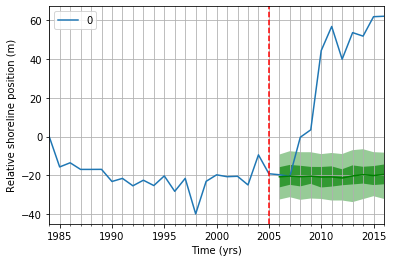

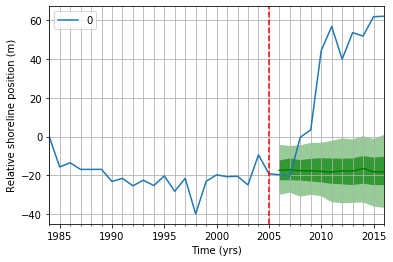

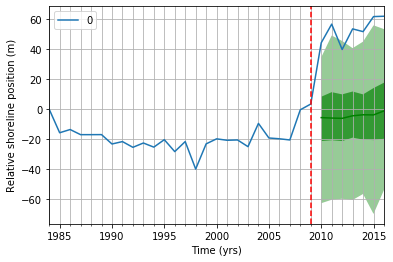

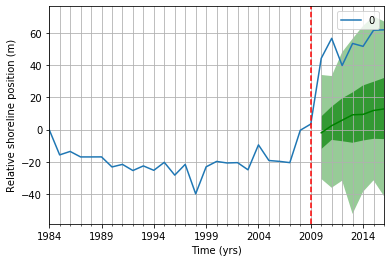

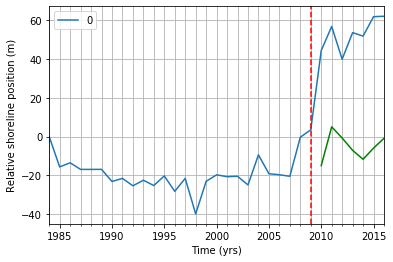

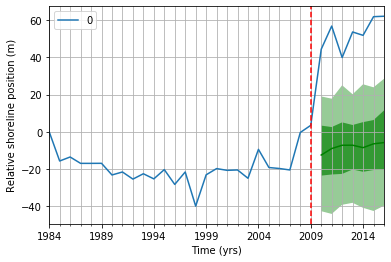

In [120]:
def plot_prob_forecast(ax, ts, fcst):
    prediction_intervals = (50.0, 90.0)
    ts.plot(ax=ax, label=fcst.item_id) 
    fcst.plot(
        prediction_intervals=prediction_intervals,
        color='g'
    ) 
    ax.axvline(x=ts.index[-(len(fcst.median)+1)], color='red', linestyle='--')
    ax.set_ylabel('Relative shoreline position (m)')
    ax.set_xlabel('Time (yrs)')
    ax.grid(which="both")
    return ax


for i in [arima_it, ets_it, simpleffn_it, deepar_it, mqcnn_it, deepssm_it]:
    fig, ax = plt.subplots()
    plot_prob_forecast(ax, next(i[1]), next(i[0]))
    plt.show()


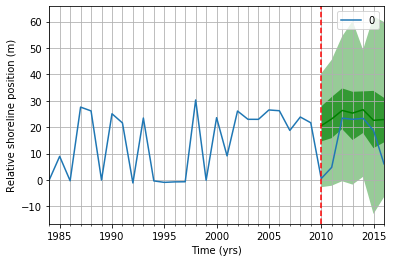

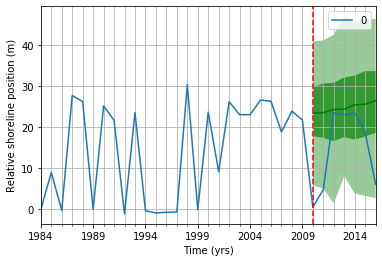

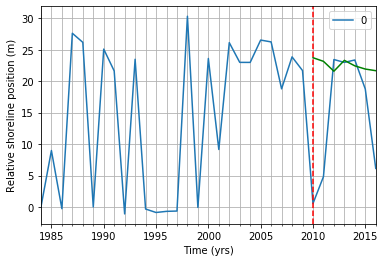

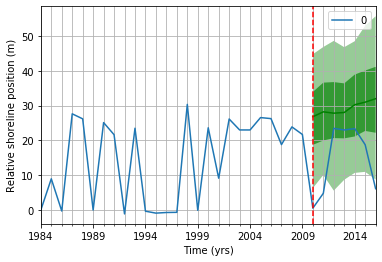

In [36]:
idx_ = np.random.choice(range(1000))


fig, ax = plt.subplots()
plot_prob_forecast(ax, tss[0][idx_], forecasts[0][idx_])
plt.show()

fig, ax = plt.subplots()
plot_prob_forecast(ax, tss[1][idx_], forecasts[1][idx_])
plt.show()

fig, ax = plt.subplots()
plot_prob_forecast(ax, tss[2][idx_], forecasts[2][idx_])
plt.show()

fig, ax = plt.subplots()
plot_prob_forecast(ax, tss[3][idx_], forecasts[3][idx_])
plt.show()


In [14]:
tr_ds, te_ds = get_gluon_ds(tf_t, sample=100)

In [21]:
from scipy import stats

from shorelineforecasting.utils.forecasting_metrics import evaluate, evaluate_ 
# from utils import get_predictor_id

y = lambda intercept, slope, x: intercept + slope * x

def ols(obs, forecast=False):
    x = range(len(obs))
    slope, intercept, _, _, _ = stats.linregress(x, obs)
    if forecast is True:
        x = range(len(obs) + metadata["prediction_length"])
    return [y(intercept, slope, x) for x in x]

def make_evaluation_predictions_lr(dataset, metrics: list):
    dataset = dataset.list_data
    results = []
    predictor_id = get_predictor_id()
    start = time.process_time()
    for i in dataset:
        fcast = ols(i["target"][:-metadata["prediction_length"]], forecast=True)
        eval_dict = evaluate_(time_series = i["target"], 
                             predicted = fcast[-metadata["prediction_length"]:], 
                             metrics = metrics)
        eval_dict["item_id"] = i["item_id"]
        eval_dict["MAE"] = eval_dict['abs_error']/metadata['prediction_length']
        eval_dict["predictor_id"] = predictor_id
        eval_dict['predictor']='linregress'
        results.append(eval_dict)
    results = pd.DataFrame(results)
    results['processing_time'] = time.process_time() - start
    return results

results = make_evaluation_predictions_lr(test_ds, metrics=["MSE", "abs_error", "abs_target_sum", "abs_target_mean", 
                                                         "seasonal_error", "MASE", "MAPE", "sMAPE"])
results


,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,item_id,MAE,predictor_id,predictor,processing_time
0,2184.934204,313.328691,478.11841,68.302630,12.352900,3.623541,1.730388,0.961622,BOX_051_151_15,44.761242,632,linregress,20.879025
1,1152.427279,225.916235,188.15791,26.879701,5.876529,5.491975,1.569784,2.000000,BOX_051_151_18,32.273748,632,linregress,20.879025
2,1540.350971,188.095510,991.53200,141.647429,17.560941,1.530145,0.297760,0.203372,BOX_051_151_21,26.870787,632,linregress,20.879025
3,49.398626,46.758159,169.36152,24.194503,7.155169,0.933554,0.284326,0.244841,BOX_051_151_30,6.679737,632,linregress,20.879025
4,1298.588458,241.767657,442.70870,63.244100,15.640881,2.208203,0.575635,0.434680,BOX_051_151_32,34.538237,632,linregress,20.879025
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37106,652.911778,149.043310,126.26665,18.038093,18.685419,1.139493,2.391625,1.747731,BOX_203_023_54,21.291901,632,linregress,20.879025
37107,406.047901,95.955425,133.00132,19.000189,15.398167,0.890231,0.630457,0.747061,BOX_203_023_64,13.707918,632,linregress,20.879025
37108,274.882671,99.012644,188.27192,26.895989,13.327109,1.061345,0.652302,0.676775,BOX_203_023_69,14.144663,632,linregress,20.879025
37109,2077.990451,295.716150,196.64207,28.091724,33.741886,1.252010,2.209574,1.647209,BOX_203_024_29,42.245164,632,linregress,20.879025


In [29]:
agg_funs = {
    "MSE": "mean",
    "MAE": "mean",
    "abs_error": "sum",
    "abs_target_sum": "sum",
    "abs_target_mean": "mean",
    "seasonal_error": "mean",
    "MASE": "mean",
    "MAPE": "mean",
    "sMAPE": "mean",
    "OWA": "mean",
    "MSIS": "mean",
    "processing_time": "mean",
}


def get_aggregate_metrics(item_metrics, agg_funs):
    res = list()
    for i, gr in item_metrics.groupby('predictor'):

        totals = dict()
        for key, agg in agg_funs.items():
            try: 
                totals[key] = gr[key].agg(agg)
            except:
                np.nan
        
        totals['predictor'] = i
        totals['predictor_id'] = gr['predictor_id'].unique()[0]
        totals['prediction_length'] = metadata['prediction_length']

        # derived metrics based on previous aggregate metrics
        totals["RMSE"] = np.sqrt(totals["MSE"])

        flag = totals["abs_target_mean"] <= 1e-8
        totals["NRMSE"] = np.divide(
            totals["RMSE"] * (1 - flag), totals["abs_target_mean"] + flag
        )

        flag = totals["abs_target_sum"] <= 1e-8
        totals["ND"] = np.divide(
            totals["abs_error"] * (1 - flag), totals["abs_target_sum"] + flag
        )
        
        res.append(totals)
    return pd.DataFrame(res)

lr_agg_metrics = get_aggregate_metrics(results, agg_funs)


In [51]:
metrics = pd.read_csv(os.path.join(data_dir, 'robustness-final.csv'))
metrics[['predictor', 'processing_time']]

,predictor,processing_time
0,SimpleFeedForwardEstimator,92.941660
1,DeepAREstimator,1978.062001
2,MQCNNEstimator,86.763150
3,DeepStateEstimator,1506.384722
4,SimpleLSTM,3425.871678
5,linregress,20.879025


In [34]:
agg_metrics_lr

,MSE,MAE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,processing_time,predictor,predictor_id,prediction_length,RMSE,NRMSE,ND
0,2510.330038,20.012718,5.198844e+06,9.442682e+06,36.349185,13.435316,1.540923,14.021865,0.82892,20.879025,linregress,632,7,50.103194,1.378386,0.550569


In [65]:
results = list()
for i in np.arange(1, 12):
    metadata['prediction_length'] = i
    tr_ds, te_ds = get_gluon_ds(tf_t)
    lr_metrics_ = make_evaluation_predictions_lr(
        dataset=te_ds, 
        metrics=[
            "MSE", "abs_error", "abs_target_sum", 
            "abs_target_mean","seasonal_error", 
            "MASE", "MAPE", "sMAPE"
        ]
    )
    results.append(get_aggregate_metrics(lr_metrics_, agg_funs))
    


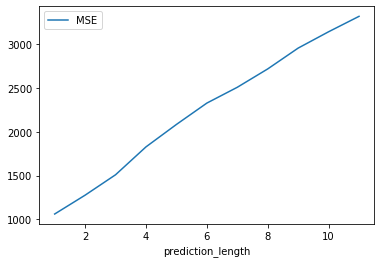

In [68]:
pd.concat(results).plot(x='prediction_length', y='MSE')

In [69]:
lr_agg_metrics = pd.concat(results)

In [71]:
lr_agg_metrics.loc[lr_agg_metrics['prediction_length']==7]

,MSE,MAE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,predictor,predictor_id,prediction_length,RMSE,NRMSE,ND
0,2510.330038,20.012718,5.198844e+06,9.442682e+06,36.349185,13.435316,1.540923,14.021865,0.82892,linregress,584,7,50.103194,1.378386,0.550569


In [28]:
agg_metrics_total = pd.read_csv(os.path.join(data_dir, 'robustness-final.csv'))

In [30]:
m = pd.concat([agg_metrics_total, lr_agg_metrics])

In [33]:
m[['predictor', 'processing_time']]

,predictor,processing_time
0,SimpleFeedForwardEstimator,92.941660
1,DeepAREstimator,1978.062001
2,MQCNNEstimator,86.763150
3,DeepStateEstimator,1506.384722
0,linregress,20.879025


In [105]:
m.groupby('method_name')['prediction_length'].count()

method_name
arima    5
ets      5
Name: prediction_length, dtype: int64

In [91]:
m.shape.to_csv(os.path.join(data_dir, "robustness.csv"), index=False, header=True)

(64, 99)